# Initial clustering approach

This notebook demonstrates how clustering of feature vectors can be used to help improve posterior inference in basket trials.

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import sys
from os.path import exists

sys.path.append('..')
sys.path.append('.')

In [3]:
import numpy as np
import pandas as pd
import arviz as az

In [4]:
from pyBasket.env import Trial, TrueResponseSiteWithFeatures
from pyBasket.common import DEFAULT_EFFICACY_CUTOFF, DEFAULT_FUTILITY_CUTOFF

In [5]:
DEBUG = True

In [6]:
num_burn_in = 1E5
num_posterior_samples = 1E5
num_chains = None # let pymc decide

In [7]:
if DEBUG:
    num_burn_in = 5E4
    num_posterior_samples = 5E4
    num_chains = 1

### Generate data

Similar set-up to CBHM paper.

In [8]:
K = 6    # the number of groups
p0 = 0.20 # null response rate
p1 = 0.40 # target response rate

true_response_rates = [p0, p0, p0, p1, p1, p1]
enrollment = [14, 10]

n = 100
pvals_map = {
    p0: [1/10] * 10,
    p1: ([0.05] * 5) + ([0.15] * 5)
}

sites = []
for k in range(K):
    true_response_rate = true_response_rates[k]
    pvals = pvals_map[true_response_rate]
    site = TrueResponseSiteWithFeatures(k, true_response_rate, enrollment, n, pvals)
    sites.append(site)

evaluate_interim = [True, True] # evaluate every interim stage
analysis_names = ['independent', 'hierarchical', 'bhm']

In [9]:
pd1 = sites[0].enroll()
pd1

PatientData:
responses [0 0 0 0 0 1 0 0 0 1 0 0 0 1]
features
[[14 10 11  9 13 14  9 11 11 11 10 11  9 16]
 [10 15 18  9  8  8  9 13  9 13 12 11  6  6]
 [ 8 11 11  8 10 13  9  8 10  9 13  9  6 18]
 [10  8 17 15 12  6  9 11 11 10 14 13 12  9]
 [ 5 16 10  6  7 11 11 10  8  7  6  8  8  8]
 [12 12  5 13  7 11 11 12 11  7  9 10 11  6]
 [ 9  6  2 15 11  9  9  7 12  9 12 11 12  7]
 [ 9  5  8  9 13 13 16 11 13 12  6  8 12  8]
 [14 10  9 11 11  6  6 11  7 12  6 11  8 13]
 [ 9  7  9  5  8  9 11  6  8 10 12  8 16  9]]

In [10]:
pd2 = sites[-1].enroll()
pd2

PatientData:
responses [0 0 1 1 0 1 1 1 0 1 0 1 0 1]
features
[[ 6  5  7  5  3  4  6  2  6  4  6  7  6  3]
 [ 4 11  4  6  3  7  6  6  5  6  5  6  5  5]
 [ 6  5  6  4  5  6  5  6  5  4  3  4  4  8]
 [ 5  3  6  4  1  8  4  4  1  4  5  3  6  5]
 [ 3  6  8 12  6  2  5  7  5  5  1  5  5  7]
 [17 13 10 16 10 14 26 16 16  9 20 16 20 10]
 [12 14  9 13 20 12 13 21 19 21 13 15 11 13]
 [14 15 21  9 14 16 13 12 13 15 14 16 16 13]
 [17 14 17 16 16 16 11  9 21 17 13 14 16 22]
 [16 14 12 15 22 15 11 17  9 15 20 14 11 14]]

In [11]:
futility_cutoff = DEFAULT_FUTILITY_CUTOFF
efficacy_cutoff = DEFAULT_EFFICACY_CUTOFF
early_futility_stop = True
early_efficacy_stop = False

In [12]:
trial = Trial(K, p0, p1, sites, evaluate_interim, 
              num_burn_in, num_posterior_samples, analysis_names, 
              futility_cutoff=futility_cutoff, efficacy_cutoff=efficacy_cutoff,
              early_futility_stop=early_futility_stop,
              early_efficacy_stop=early_efficacy_stop,              
              num_chains=num_chains)

done = trial.reset()
while not done:
    done = trial.step()


########## Stage=0 ##########

Analysis independent Group 0 (OPEN): 1/14
Analysis hierarchical Group 0 (OPEN): 1/14
Analysis bhm Group 0 (OPEN): 1/14

Analysis independent Group 1 (OPEN): 5/14
Analysis hierarchical Group 1 (OPEN): 5/14
Analysis bhm Group 1 (OPEN): 5/14

Analysis independent Group 2 (OPEN): 3/14
Analysis hierarchical Group 2 (OPEN): 3/14
Analysis bhm Group 2 (OPEN): 3/14

Analysis independent Group 3 (OPEN): 5/14
Analysis hierarchical Group 3 (OPEN): 5/14
Analysis bhm Group 3 (OPEN): 5/14

Analysis independent Group 4 (OPEN): 4/14
Analysis hierarchical Group 4 (OPEN): 4/14
Analysis bhm Group 4 (OPEN): 4/14

Analysis independent Group 5 (OPEN): 7/14
Analysis hierarchical Group 5 (OPEN): 7/14
Analysis bhm Group 5 (OPEN): 7/14

Running inference for: independent


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [θ]


Sampling 1 chain for 50_000 tune and 50_000 draw iterations (50_000 + 50_000 draws total) took 38 seconds.


,prob,futile,effective
k,,,
0,0.03570,True,False
1,0.71954,False,False
2,0.29610,False,False
3,0.72132,False,False
4,0.51506,False,False
5,0.94928,False,True


Running inference for: hierarchical


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [α, β, θ]


Sampling 1 chain for 50_000 tune and 50_000 draw iterations (50_000 + 50_000 draws total) took 89 seconds.


,prob,futile,effective
k,,,
0,0.13244,False,False
1,0.65976,False,False
2,0.36718,False,False
3,0.66042,False,False
4,0.52234,False,False
5,0.87078,False,False


Running inference for: bhm


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [tausq, theta0, e]


Sampling 1 chain for 50_000 tune and 50_000 draw iterations (50_000 + 50_000 draws total) took 70 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


,prob,futile,effective
k,,,
0,0.03292,True,False
1,0.72530,False,False
2,0.29048,False,False
3,0.72082,False,False
4,0.50964,False,False
5,0.95576,False,True



########## Stage=1 ##########

Analysis independent Group 0 (EARLY_STOP_FUTILE): 1/14
Analysis hierarchical Group 0 (OPEN): 3/24
Analysis bhm Group 0 (EARLY_STOP_FUTILE): 1/14

Analysis independent Group 1 (OPEN): 6/24
Analysis hierarchical Group 1 (OPEN): 6/24
Analysis bhm Group 1 (OPEN): 6/24

Analysis independent Group 2 (OPEN): 4/24
Analysis hierarchical Group 2 (OPEN): 4/24
Analysis bhm Group 2 (OPEN): 4/24

Analysis independent Group 3 (OPEN): 8/24
Analysis hierarchical Group 3 (OPEN): 8/24
Analysis bhm Group 3 (OPEN): 8/24

Analysis independent Group 4 (OPEN): 8/24
Analysis hierarchical Group 4 (OPEN): 8/24
Analysis bhm Group 4 (OPEN): 8/24

Analysis independent Group 5 (OPEN): 11/24
Analysis hierarchical Group 5 (OPEN): 11/24
Analysis bhm Group 5 (OPEN): 11/24

Running inference for: independent


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [θ]


Sampling 1 chain for 50_000 tune and 50_000 draw iterations (50_000 + 50_000 draws total) took 37 seconds.


,prob,futile,effective
k,,,
0,0.16370,None,False
1,0.77882,None,False
2,0.42016,None,False
3,0.95492,None,True
4,0.95346,None,True
5,0.99808,None,True


Running inference for: hierarchical


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [α, β, θ]


Sampling 1 chain for 50_000 tune and 50_000 draw iterations (50_000 + 50_000 draws total) took 85 seconds.


,prob,futile,effective
k,,,
0,0.46064,None,False
1,0.83894,None,False
2,0.60334,None,False
3,0.95534,None,True
4,0.95426,None,True
5,0.99650,None,True


Running inference for: bhm


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [tausq, theta0, e]


Sampling 1 chain for 50_000 tune and 50_000 draw iterations (50_000 + 50_000 draws total) took 71 seconds.


,prob,futile,effective
k,,,
0,0.13440,None,False
1,0.76046,None,False
2,0.38000,None,False
3,0.94830,None,True
4,0.94742,None,True
5,0.99872,None,True


### Check last results

### Independent

In [13]:
analysis_name = analysis_names[0]
analysis_name

'independent'

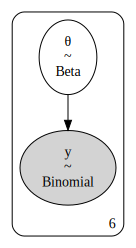

In [15]:
trial.visualise_model(analysis_name)

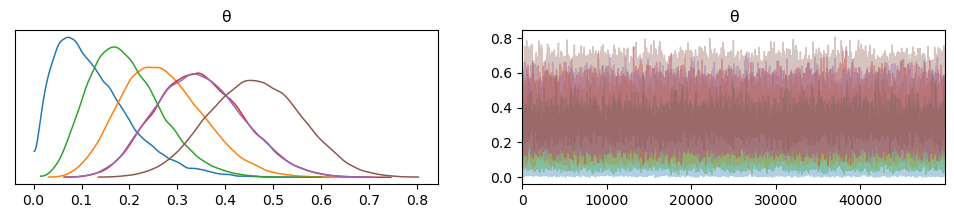

In [16]:
trial.plot_trace(analysis_name, -1)

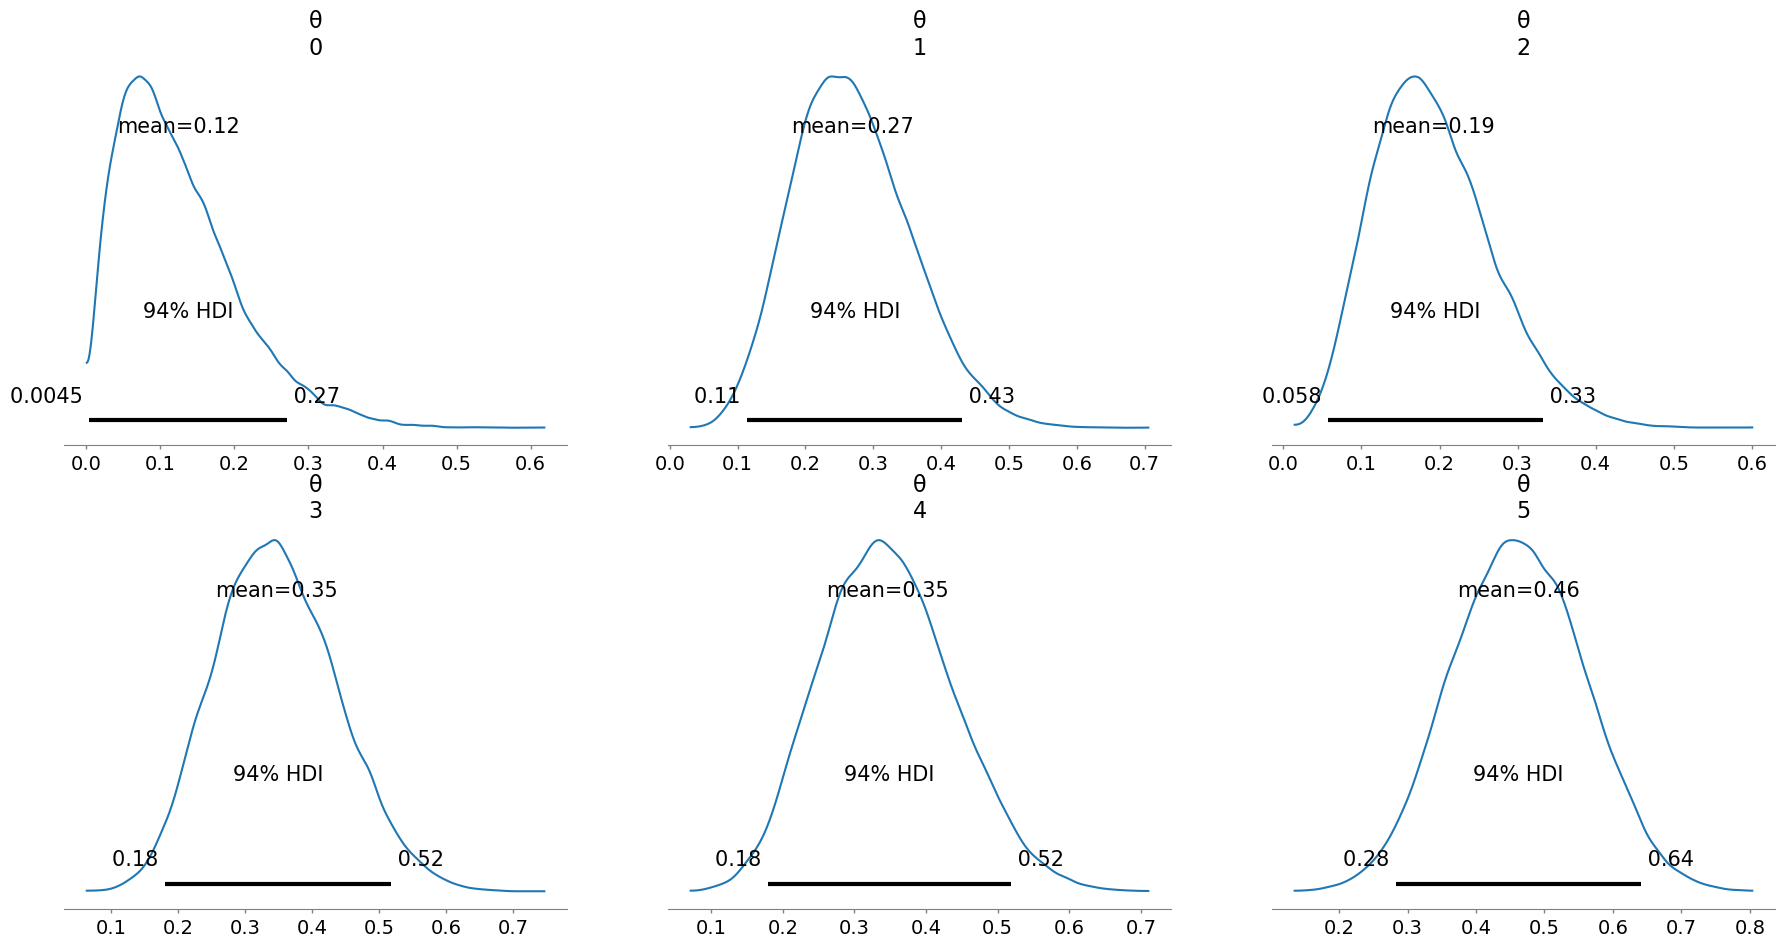

In [17]:
trial.plot_posterior(analysis_name, -1)

In [18]:
trial.final_report(analysis_name)

,status,nnz,total
k,,,
0,EARLY_STOP_FUTILE,1,14
1,COMPLETED_INEFFECTIVE,6,24
2,COMPLETED_INEFFECTIVE,4,24
3,COMPLETED_EFFECTIVE,8,24
4,COMPLETED_EFFECTIVE,8,24
5,COMPLETED_EFFECTIVE,11,24


### Hierarchical

In [19]:
analysis_name = analysis_names[1]
analysis_name

'hierarchical'

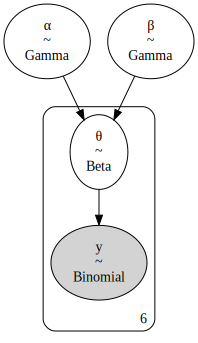

In [20]:
trial.visualise_model(analysis_name)

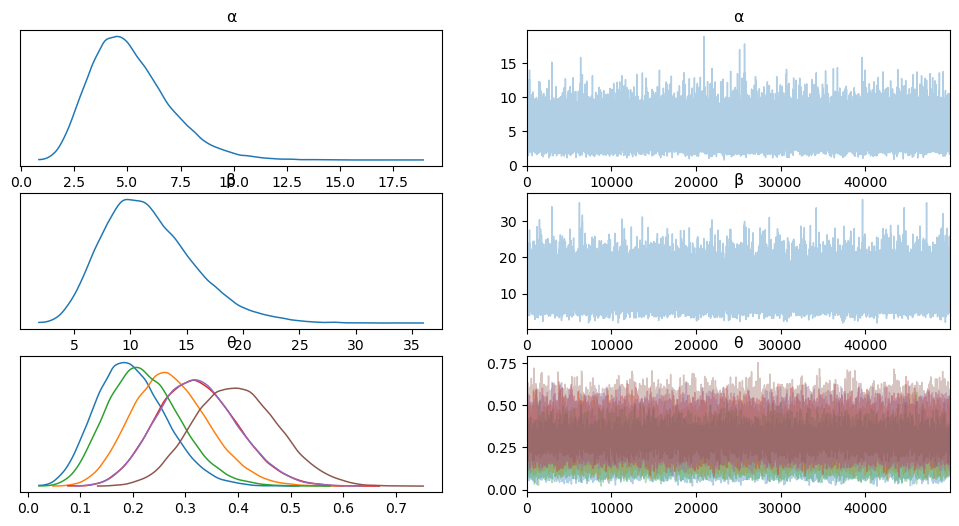

In [21]:
trial.plot_trace(analysis_name, -1)

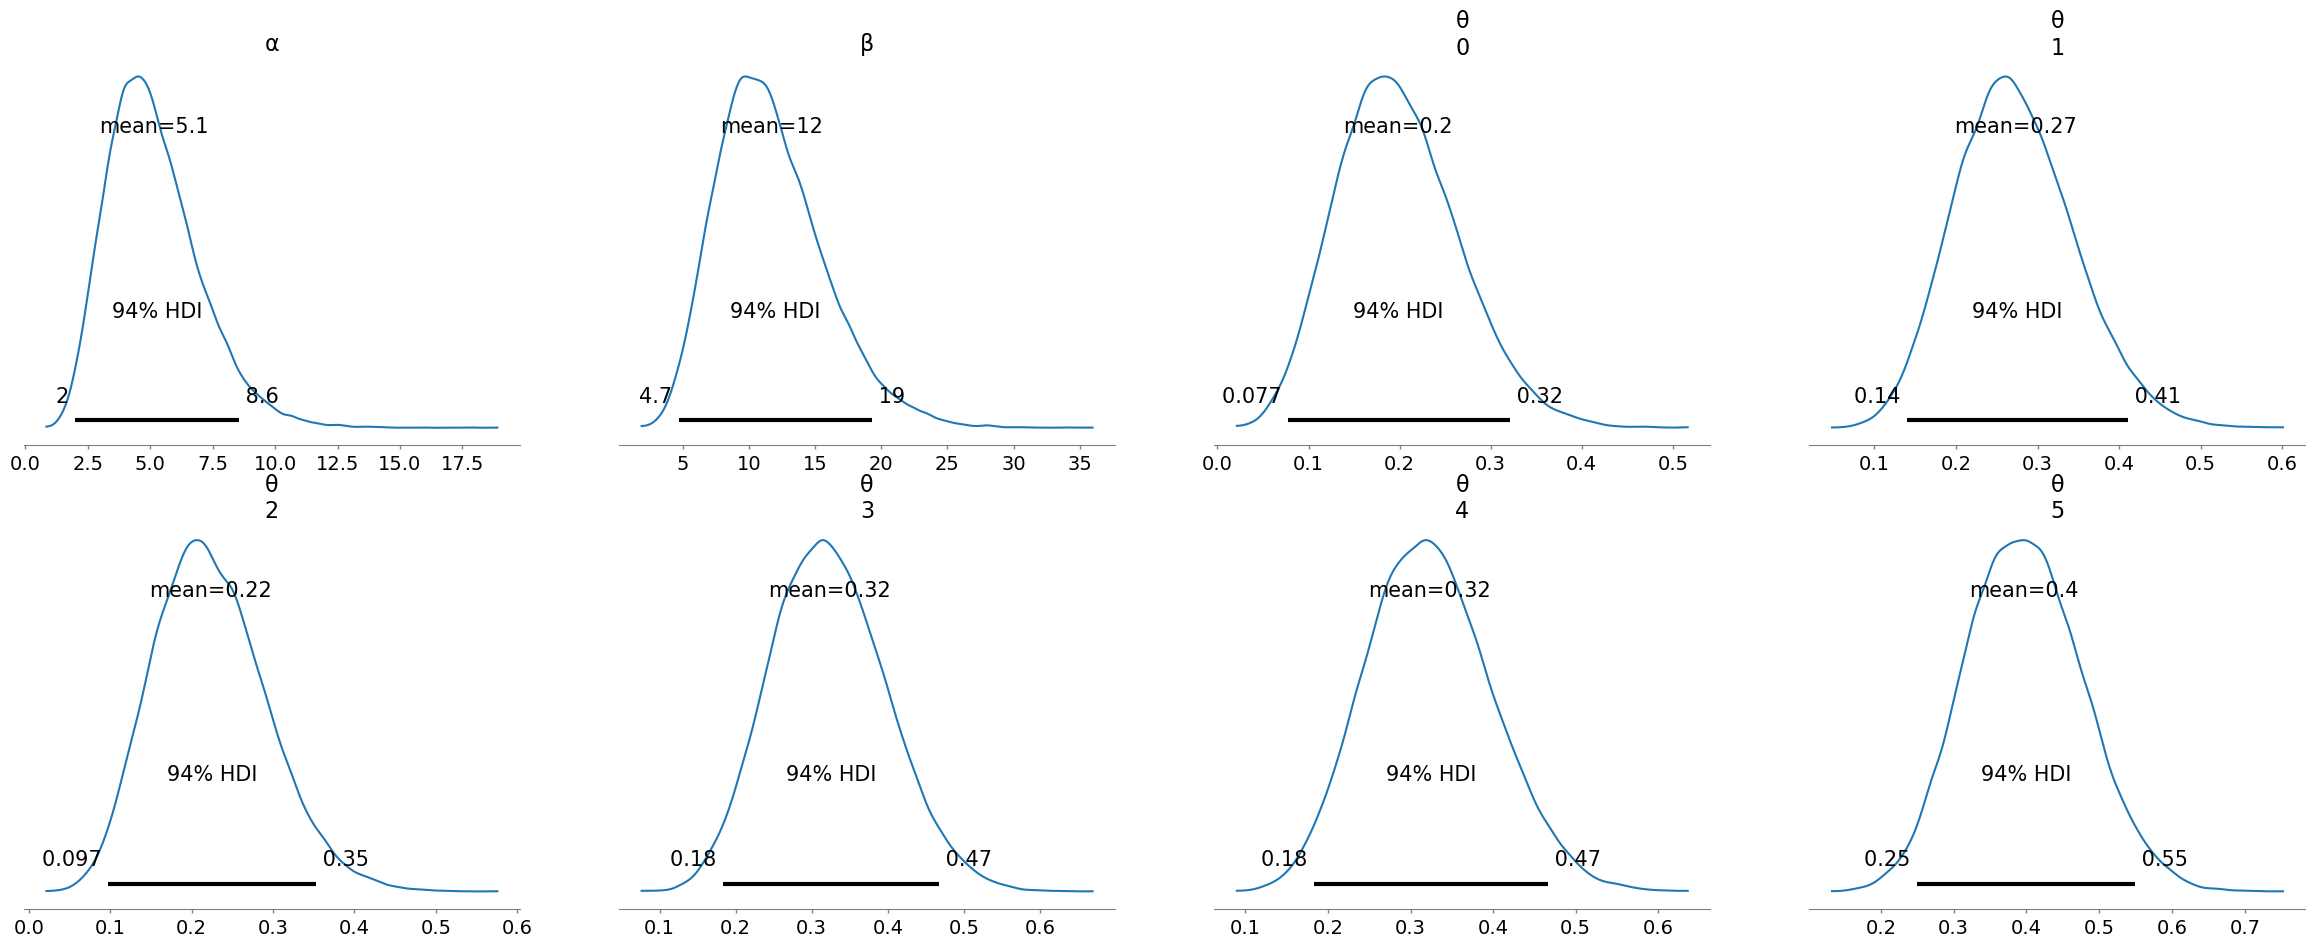

In [22]:
trial.plot_posterior(analysis_name, -1)

In [23]:
trial.final_report(analysis_name)

,status,nnz,total
k,,,
0,COMPLETED_INEFFECTIVE,3,24
1,COMPLETED_INEFFECTIVE,6,24
2,COMPLETED_INEFFECTIVE,4,24
3,COMPLETED_EFFECTIVE,8,24
4,COMPLETED_EFFECTIVE,8,24
5,COMPLETED_EFFECTIVE,11,24


### BHM

In [24]:
analysis_name = analysis_names[2]
analysis_name

'bhm'

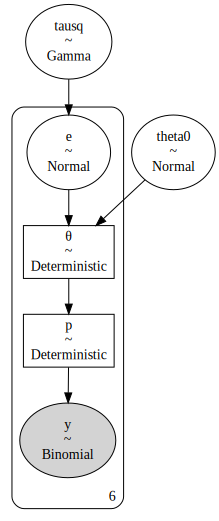

In [25]:
trial.visualise_model(analysis_name)

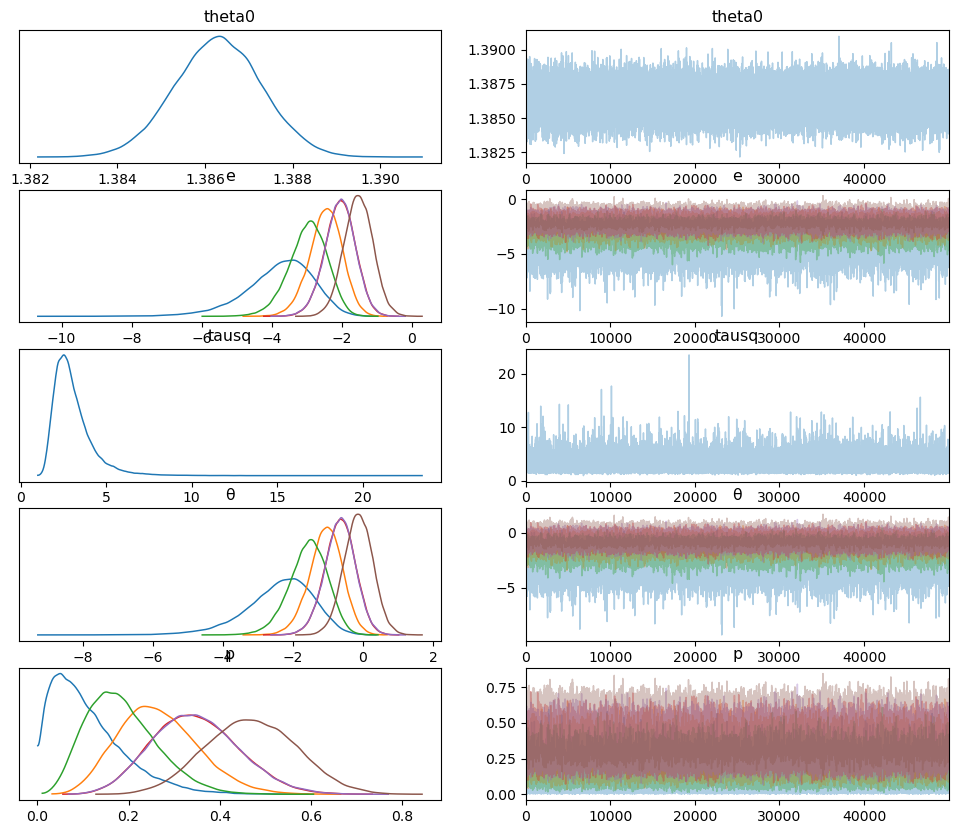

In [26]:
trial.plot_trace(analysis_name, -1)

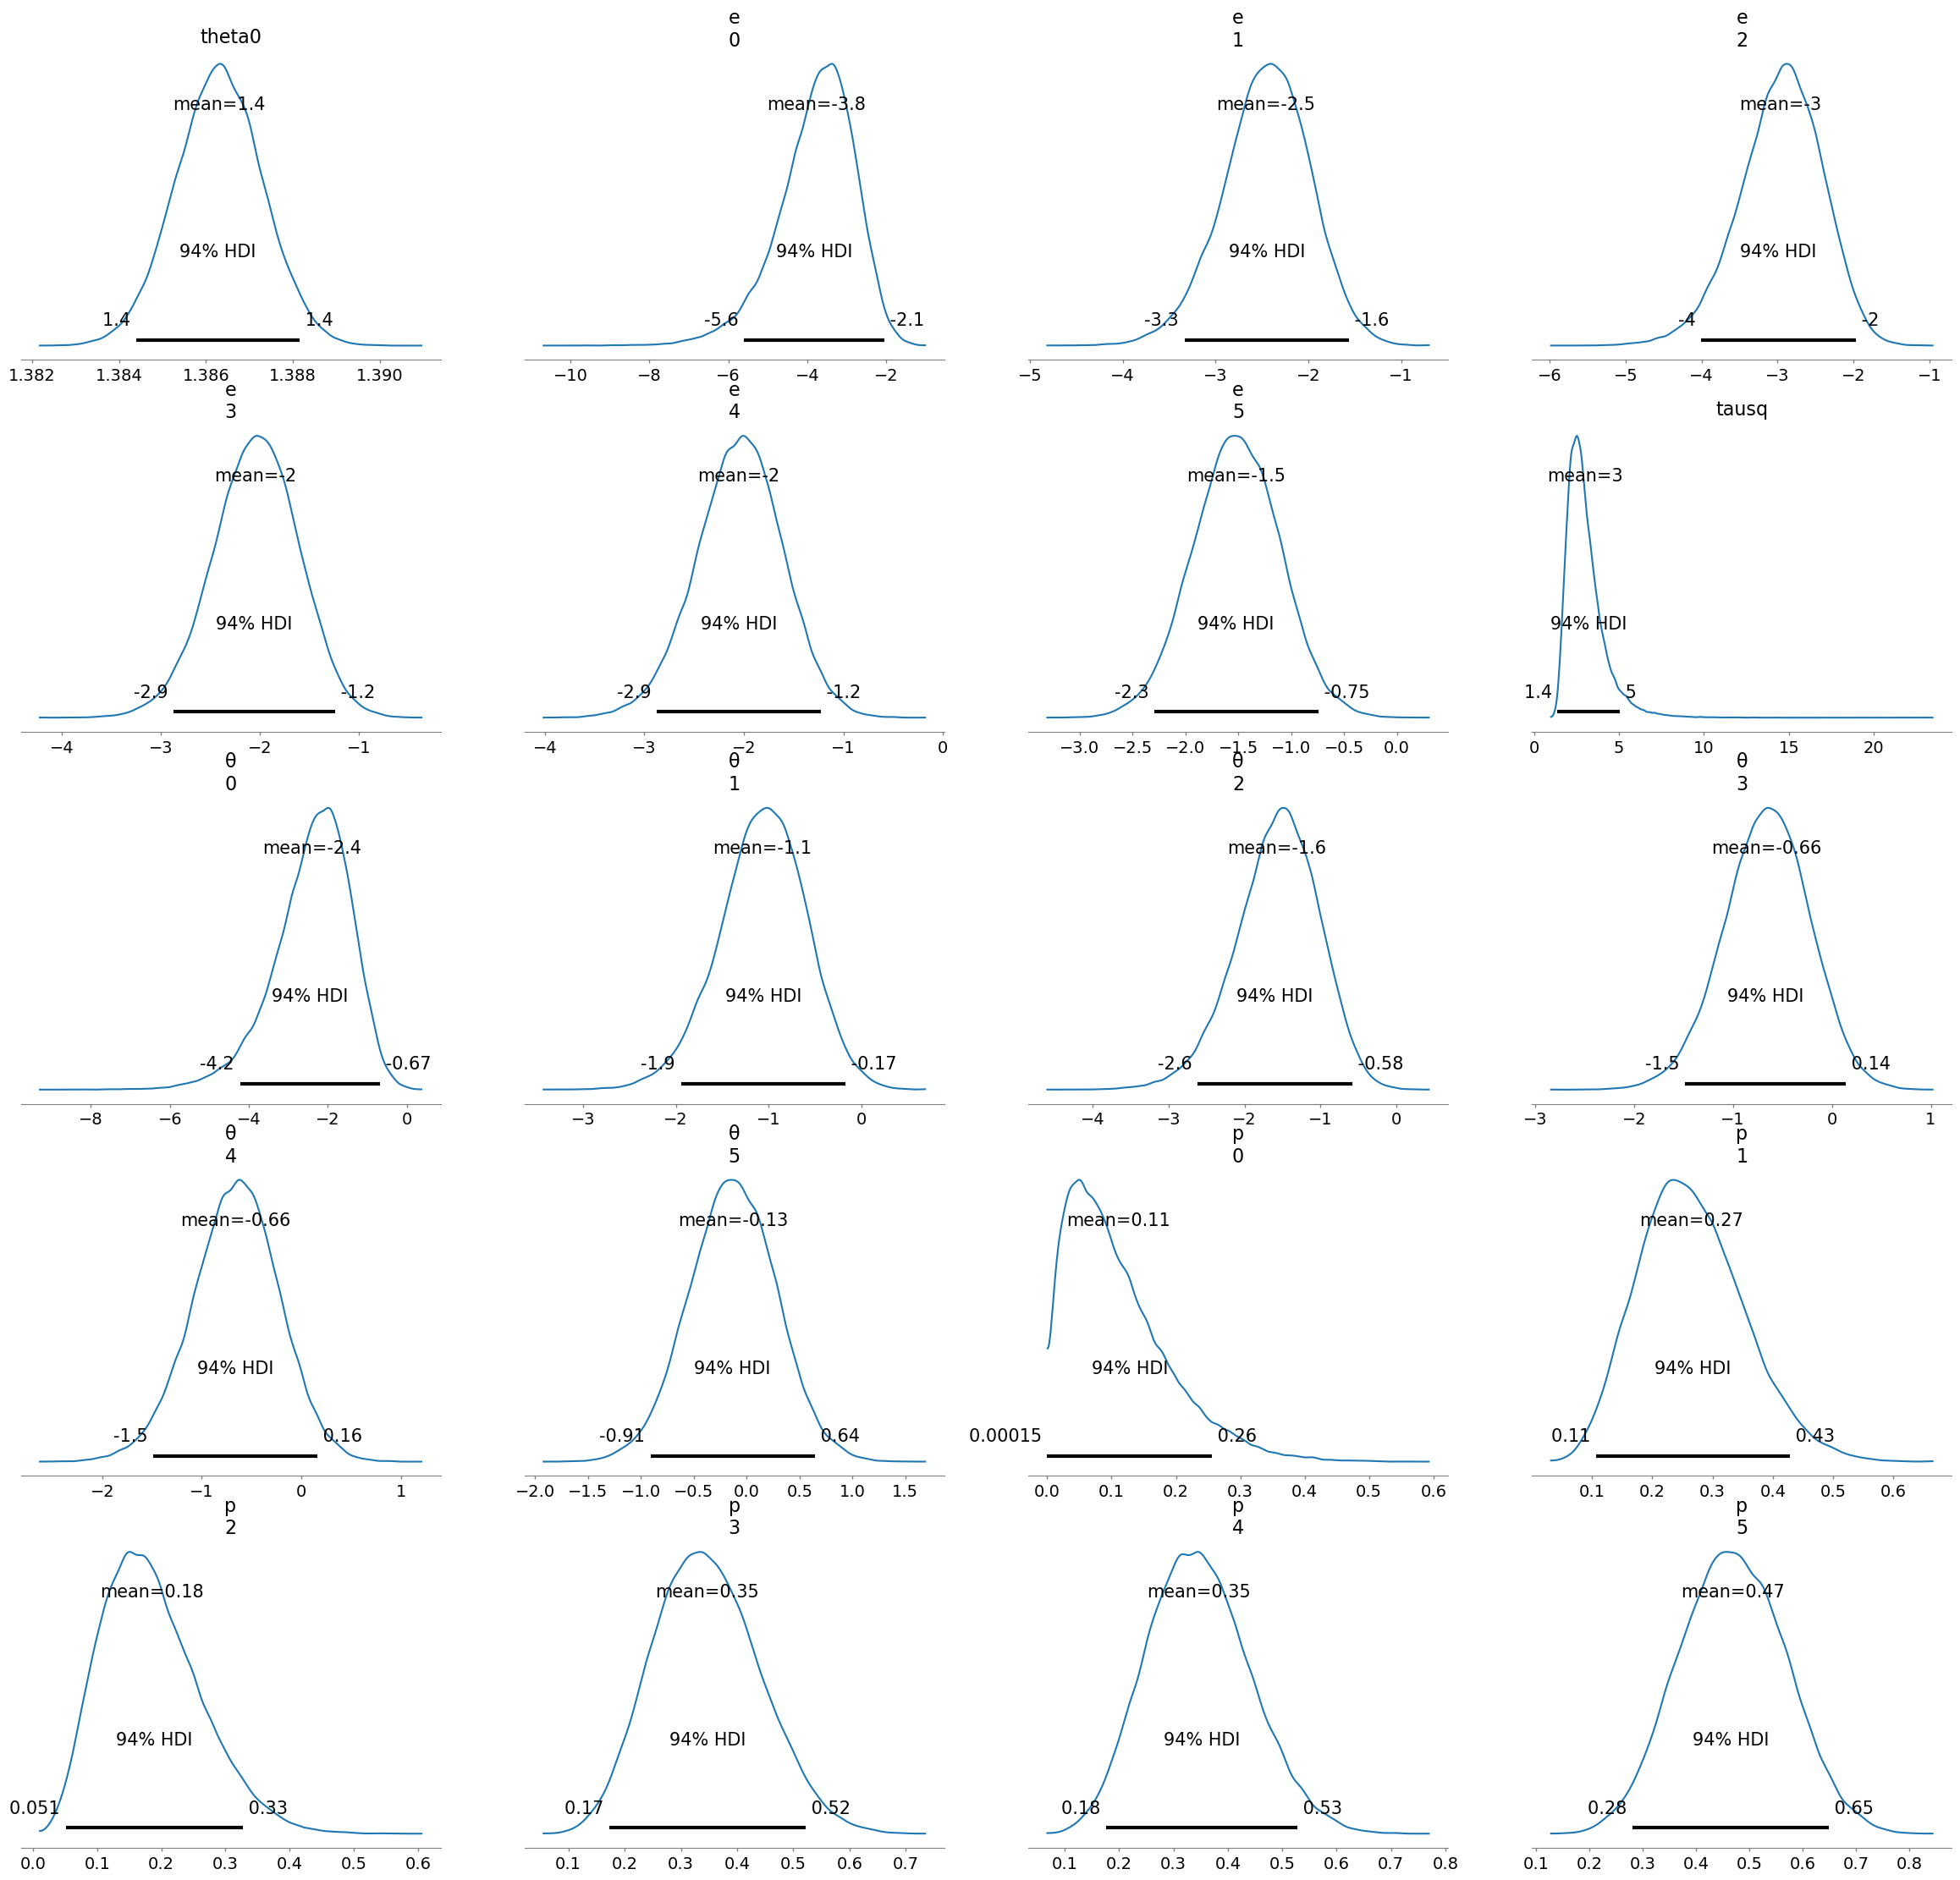

In [27]:
trial.plot_posterior(analysis_name, -1)

In [28]:
trial.final_report(analysis_name)

,status,nnz,total
k,,,
0,EARLY_STOP_FUTILE,1,14
1,COMPLETED_INEFFECTIVE,6,24
2,COMPLETED_INEFFECTIVE,4,24
3,COMPLETED_EFFECTIVE,8,24
4,COMPLETED_EFFECTIVE,8,24
5,COMPLETED_EFFECTIVE,11,24
